# Exploratory Data Analysis Notebook
## Visualise the data and the summary statistics
### Contents
1. Summary statistics
2. Principal component analysis (PCA)
3. Pairplots and horizonral pairplots
4. Correlation matrices
5. Flood map evaluations

In [1]:
from os.path import join
from itertools import compress
import numpy as np
import pandas as pd
import tensorflow as tf
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix as cm
from sklearn.decomposition import PCA

plt.rcParams["font.family"] = "Times New Roman"

# helper functions
from importlib import reload
import model_utils
import data_utils
import viz_utils

# settings
viz = True
storm = ""  # e.g., "roanu" or "" for all events
temporal = False
binary = False

# set up the environment
wd = join("..", "data")
imdir = join(wd, 'images')

reload(model_utils)
base_gdf, features, columns = model_utils.load_raw_data(wd, data_utils.default_features, temporal, binary)

print(f"Number of unique events: {base_gdf.event.nunique()}")

Error for cuba:
"['precip'] not in index"


AssertionError: dist_pw has NaNs for irma_tampasouth_0.

## 1. Summary Statistics

In [ ]:
# examine gdf

summary_stats = False

if summary_stats:
    n = len(gdf)

    if binary:
        n1 = gdf['floodfrac'].sum()
        n0 = n - n1
        print("Zeros:", n0)
        print("Ones:", n1)
        print(f"Null values: {sum(gdf.isnull().any())}")

    gdf.describe()

## Preliminary Visualisations
Look at correlations and distributions of data. Skewed data will need to be log-normlised, and most data will need to be normalised. If there are outliers, it may be necessary to remove them too. Do this for binary and nonbinary data.

In [6]:
# horizontal pairplot
viz = False

def pearsonr_corr(x, y):
    return pearsonr(x, y)[0]

def pearsonr_pval(x, y):
    return pearsonr(x, y)[1]

if viz:
    sns.set(style="ticks")
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
    pplot = sns.pairplot(data=gdf, y_vars=['floodfrac'], x_vars=features,
                         hue="floodfrac", palette='YlGnBu', kind='scatter')
    fig = pplot.fig
    fig.savefig(join(imdir, "eda", f"horiz_pairplot_binary{binary}.png"))

So elevation, slope_pw, dist_pw, and soilcarbon all seem quite skewed. Additionally, elevation and slope_pw have a very large spread. It might be good to log-transform the skewed data and cut more extreme values from the very spread-out data.

In [7]:
# correlation matrix with p-values
if viz:
    sns.set(style="ticks")
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
    
    fig, ax = plt.subplots(1, 2, figsize=(30, 10))

    cmat = sns.heatmap(gdf.corr(method=pearsonr_corr), annot=True, ax=ax[0], linewidths=.5, fmt='.1g',
                       cmap="Spectral")
    cmat.set(title="Correlation matrix\n")
    
    cmap = plt.get_cmap('Reds_r').copy()
    cmap.set_over('grey')
    cmat = sns.heatmap(gdf.corr(method=pearsonr_pval), annot=True, ax=ax[1], linewidths=.5, fmt='.1g',
                       cmap=cmap, vmax=0.05)
    cmat.set(title="p-value\n")

    fig.savefig(join(imdir, 'eda', f"correlation matrix binary{binary}.png"))

In [8]:
# pairplot -- WARNING: this takes forever to run
if viz:
    sns.set(style="ticks")
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
    
    pplot = sns.pairplot(gdf, hue="floodfrac", palette='YlGnBu', kind='scatter', diag_kind='kde');

    fig = pplot.fig
    fig.savefig(join(imdir, 'eda', f"pairplot_binary{binary}.png"))
    
    !say finished making pair plot

## Data cleaning and transforms
Functions for data cleaning and saving the transform info to the metadata. Not doing this for now as RF doesn't really need it.


```
** functions added to random_funcs.py
```

## 2. Principle Component Analysis
Use PCA to project the dataset into two-dimensions which explain most of the variablity within the data. These principal components can be used to determine how similar the data is between different events. First we normalise the data then fit a 2-component PCA to it. Then each event is projected onto the same axis. Reference: [Barzin (2022): Where are all the jobs?](https://www.oxfordmartin.ox.ac.uk/publications/where-are-all-the-jobs-a-machine-learning-approach-for-high-resolution-urban-employment-prediction-in-developing-countries/).

In [9]:
pca = False

if pca:
    fig, ax = plt.subplots(1, figsize=(15, 10))
    cmap = plt.get_cmap('Spectral').copy()
    nevents = gdf.event.nunique()

    gdf_norm = gdf.drop(columns=['event', 'geometry', 'floodfrac'])
    gdf_norm = (gdf_norm - gdf_norm.mean()) / gdf_norm.std()

    pca = PCA(2)
    fit = pca.fit(gdf_norm)
    gdf_norm['event'] = gdf['event']

    for i, event in enumerate(sorted([*gdf_norm.event.unique()])):
        gdf_event = gdf_norm[gdf_norm.event == event]
        gdf_event = gdf_event.drop(columns='event')
        gdf_r = fit.transform(gdf_event)
        ax.scatter(gdf_r[:, 0], gdf_r[:, 1], alpha=0.4, s=2, color=cmap(i / nevents), label=event.replace("_", ", "))

    # overall PCA contributions
    df_event = gdf.drop(columns=['event','geometry', 'floodfrac'])
    df_event = (df_event - df_event.mean()) / df_event.std()
    df_r = pca.fit(df_event).transform(df_event)
    ax.set_xlabel(f"Principal Component 1: {pca.explained_variance_ratio_[0] * 100:.02f}%", fontsize=15)
    ax.set_ylabel(f"Principal Component 2: {pca.explained_variance_ratio_[1] * 100:.02f}%", fontsize=15)


    # viz settings
    ax.set_ylim((-10, 10))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([-4, 0, 4])
    ax.set_yticks([-10, 0, 10])
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    legend = ax.legend(loc='best', title="Events")
    for x in legend.legendHandles: x._sizes[0] = 100
    for x in legend.legendHandles: x.set_alpha(0.8)
    ax.set_title("PCA of Entire Dataset", fontsize=20);


    fig.savefig(join(imdir, 'eda', 'PCA_all.png'), bbox_inches='tight')

The events show similarity in terms of the first PC, but show more variance and are more differentiated across the second component. We use a Factor Loading Plot to visualise which features are contributing most to the second component.

In [10]:
if pca:
    fig, ax = plt.subplots(1, figsize=(12, 8))
    cmap = plt.get_cmap('YlGnBu').copy()

    loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
    loading_list = [*pca.components_.T]
    nfeatures = len(features)

    for i, loading, feature in zip(range(nfeatures), loading_list, features):
        magnitude = sum(abs(loading))
        ax.scatter(loading[0], loading[1], label=feature, color=cmap(magnitude), s=(200 * magnitude))
        ax.annotate(feature, (loading[0], loading[1]), xytext=(5, 5), textcoords="offset pixels", fontsize=12)


    # viz settings
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    legend = ax.legend(loc='best', title="Features")
    for x in legend.legendHandles: x._sizes[0] = 100
    for x in legend.legendHandles: x.set_alpha(0.8)
    ax.set_xlabel("Principal Component 1", fontsize=15)
    ax.set_ylabel("Principal Component 2", fontsize=15)
    ax.set_title("PCA Factor Loading Plot", fontsize=20);


    fig.savefig(join(imdir, 'eda', 'PCA_factor-loading.png'), bbox_inches='tight')

So the storms are mostly being differentiated along PC2, of which Aqueduct, average wind speed, and precipitation are the main components. This implies that differences between events are more related to the storm intensity than to local characteristics.

In [11]:
if pca:
    # fit one event at a time
    storm = 'roanu'
    cmap = plt.get_cmap('YlGnBu').copy()
    pca = PCA(2)

    # extract subset of data
    events = sorted([*gdf.event.unique()])
    events = [x for x in events if storm in x]
    nevents = len(events)
    gdf_storm = gdf[gdf['event'].isin(events)]

    # normalise data
    gdf_norm = gdf_storm.drop(columns=['event','geometry', 'floodfrac'])
    gdf_norm = (gdf_norm - gdf_norm.mean()) / gdf_norm.std()

    # fit PCA
    fit = pca.fit(gdf_norm)

    gdf_norm['event'] = gdf_storm['event']

    # plotting
    fig, ax = plt.subplots(1, figsize=(15, 10))
    for i, event in enumerate(events):
        df_event = gdf_norm[gdf_norm.event == event].drop(columns=['event'])
        X = fit.transform(df_event)

        ax.scatter(X[:, 0], X[:, 1], alpha=0.4, s=2, color=cmap(i / nevents), label=event.replace("_", ", ").capitalize())

    # overall PCA contributions
    ax.set_xlabel(f"Principal Component 1: {pca.explained_variance_ratio_[0] * 100:.02f}%", fontsize=15)
    ax.set_ylabel(f"Principal Component 2: {pca.explained_variance_ratio_[1] * 100:.02f}%", fontsize=15)


    # viz settings
    ax.set_ylim((-10, 10))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([-4, 0, 4])
    ax.set_yticks([-10, 0, 10])
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    legend = ax.legend(loc='best', title="Events")
    for x in legend.legendHandles: x._sizes[0] = 100
    for x in legend.legendHandles: x.set_alpha(0.8)
    ax.set_title(f"PCA of {storm.capitalize()} Dataset", fontsize=20);

    fig.savefig(join(imdir, 'eda', f'PCA_{storm}.png'))

## 5. Flood map correlations

In [3]:
from viz_utils import soge_colours
from matplotlib.colors import ListedColormap

def csi(y_true, y_pred):
    """Critical success index"""
    confusion_matrix = cm(y_true, y_pred)
    TP = confusion_matrix[1, 1]
    FP = confusion_matrix[0, 1] #(row, col) = (true, pred)
    FN = confusion_matrix[1, 0]
    csi = TP / (TP + FP + FN)  # critical success index
    return csi

run_floodmap_comps = True

In [4]:
if run_floodmap_comps:
    gdf = base_gdf.copy(deep=True)
    flood_thresh = 0
    # gdf['floodfrac'] = gdf['floodfrac'].apply(lambda x: 1 if x > flood_thresh else 0)
    print(f"Deltares - Flood map correlation: {gdf['floodfrac'].corr(gdf['deltares']):.2%}")
    print(f"Aqueduct - Flood map correlation: {gdf['floodfrac'].corr(gdf['aqueduct']):.2%}")
    
    
    # check CSIs of flood hazard maps
    csis = {}
    for source in ['aqueduct', 'deltares']:  
        
        floodfrac = [*(gdf['floodfrac'] > flood_thresh).astype(int)]
        flood_source = [*(gdf[source] > flood_thresh).astype(int)]

        csi_score = csi(floodfrac, flood_source)
        csis[source] = csi_score
        print(f"CSI {source.capitalize()}: {csi_score:.4f}")

Deltares - Flood map correlation: 43.58%
Aqueduct - Flood map correlation: 44.71%
CSI Aqueduct: 0.3880
CSI Deltares: 0.3636


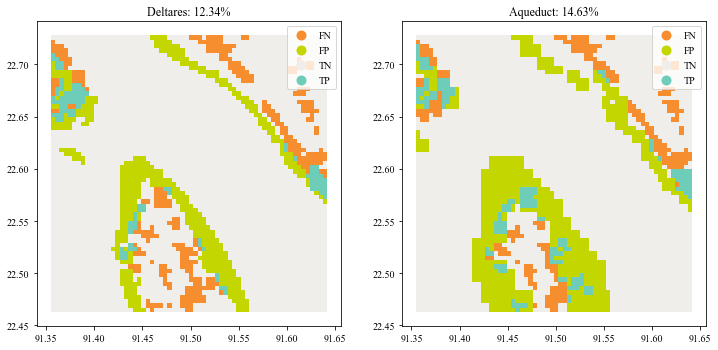

In [6]:
if run_floodmap_comps:
    storm = 'roanu'
    region = 'chittagong'
    subregion = 0
    
    cm_cols = {'TP': soge_colours['light turquoise'],
               'TN': soge_colours['beige'],
               'FP': soge_colours['yellowish green'],
               'FN': soge_colours['orange']}

    cm_categories = ListedColormap([cm_cols['FN'], cm_cols['FP'], cm_cols['TN'], cm_cols['TP']])

    gdf['floodfrac'] = gdf['floodfrac'].apply(lambda x: 1 if x > flood_thresh else 0).astype(int)
    gdf['aqueduct'] = gdf['aqueduct'].apply(lambda x: 1 if x > flood_thresh else 0).astype(int)
    gdf['deltares'] = gdf['deltares'].apply(lambda x: 1 if x > flood_thresh else 0).astype(int)

    gdf['deltares_cm'] = gdf[['floodfrac', 'deltares']].apply(lambda row: model_utils.confusion_label(row[0], row[1]), axis=1)
    gdf['aqueduct_cm'] = gdf[['floodfrac', 'aqueduct']].apply(lambda row: model_utils.confusion_label(row[0], row[1]), axis=1)

    fix, ax = plt.subplots(1, 2, figsize=(12, 6))

    gdf_event = gdf[gdf.event==f'{storm}_{region}_{subregion}']
    gdf_event.plot('deltares_cm', categorical=True, legend=True, ax=ax[0], cmap=cm_categories);
    gdf_event.plot('aqueduct_cm', categorical=True, legend=True, ax=ax[1], cmap=cm_categories);

    csi_deltares = csi(gdf_event['floodfrac'], gdf_event['deltares'])
    csi_aqueduct = csi(gdf_event['floodfrac'], gdf_event['aqueduct'])
    
    ax[0].set_title(f"Deltares: {csi_deltares:.2%}")
    ax[1].set_title(f"Aqueduct: {csi_aqueduct:.2%}");


    plt.savefig(join(imdir, "datasets", f"floodmaps_compare_{storm}_{region}_{subregion}.png"), bbox_inches="tight")

# Visualisation

In [32]:
# visualise all flood fractions
runme = True
feature = 'deltares'
if runme:
    gdf = model_utils.load_spatial_data(wd)
    events = [*gdf.event.unique()]
    cmap, _, _ = viz_utils.cmap_key[feature]
    
    for event in events:
        gdf_event = gdf[gdf['event'] == event]
        fig, ax = plt.subplots()
        
        gdf_event.plot(feature, cmap=cmap, ax=ax, legend=True)
        
        ax.set_xticks([])
        ax.set_yticks([])

        fig.savefig(join(imdir, "datasets", feature, f"{event}.png"), bbox_inches="tight")
        print(f"Finished mapping {feature} for {event}.")
        plt.close(fig)

Finished mapping deltares for irma_tampasouth_0.
Finished mapping deltares for irma_jacksonvillesouth_0.
Finished mapping deltares for gombe_mossuril_5.
Finished mapping deltares for ian_cuba_9.
Finished mapping deltares for ian_cuba_16.
Finished mapping deltares for batsirai_menabe_0.
Finished mapping deltares for batsirai_menabe_1.
Finished mapping deltares for ian_cuba_4.
Finished mapping deltares for batsirai_mananjary_0.
Finished mapping deltares for goni_tiwi_0.
Finished mapping deltares for roanu_satkania_0.
Finished mapping deltares for ian_cuba_8.
Finished mapping deltares for gombe_mossuril_4.
Finished mapping deltares for irma_jacksonvillesouth_1.
Finished mapping deltares for irma_tampasouth_1.
Finished mapping deltares for batsirai_tsiribihina_0.
Finished mapping deltares for goni_bato_0.
Finished mapping deltares for roanu_chittagong_0.
Finished mapping deltares for nakri_tuyhoa_0.
Finished mapping deltares for ian_cuba_3.
Finished mapping deltares for roanu_barguna_0.
Fi

In [18]:
# view all the data points
runme = True

reload(viz_utils)

events = [*gdf.event.unique()]
nevents = len(events)

if runme:
    for event in (pbar := tqdm(events)):
        pbar.set_description("Processing %s" % event)
        fig, axs = plt.subplots(nfeatures + 1, figsize=(2, 2 * (nfeatures + 1)))
        
        # plot floodfrac
        ax = axs[0]
        gdf_event = gdf[gdf['event'] == event]
        gdf_event.plot("floodfrac", ax=ax, legend=True,
                       cmap=viz_utils.cmap_key["floodfrac"][0])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Flood: {event}")
        
        # plot features
        for fi, feature in enumerate(features):
            ax = axs[fi+1]
            
            cmap, under, over = viz_utils.cmap_key[feature]
            cmap = plt.get_cmap(cmap).copy()
            cmap.set_under(under, 1.0)
            cmap.set_over(over, 1.0)
            
            vmin, vmax = viz_utils.cmap_range[feature]
            
            gdf_event.plot(feature, ax=ax, cmap=cmap,
                          vmin=vmin, vmax=vmax, legend=True)
            
            ax.set_title(feature)
            ax.set_xticks([])
            ax.set_yticks([])

        fig.savefig(join(imdir, "datasets", f"{event}.png"), bbox_inches="tight")
        plt.close(fig)

Processing iota_loweraguanbasin_0: 100%|█████████████████████████████| 30/30 [05:18<00:00, 10.61s/it]


## 4. Inspect elevation outliers

In [61]:
gdf['elevation'].describe()

count    122880.000000
mean         -4.445891
std         138.083744
min       -1083.769231
25%         -11.000000
50%           0.531331
75%           8.165490
max        1496.661987
Name: elevation, dtype: float64

elev < -1000m ['goni_tiwi_0']
elev < -500m ['goni_tiwi_0' 'goni_bato_0' 'rai_hinunangan_0' 'goni_virac_0']


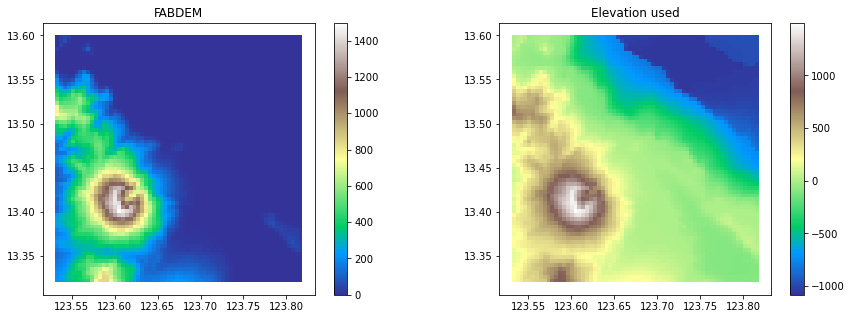

In [62]:
# inspect high elevation data
print(f"elev > 1000m {gdf[gdf['elevation'] > 1000]['event'].unique()}")
print(f"elev > 500m {gdf[gdf['elevation'] > 500]['event'].unique()}")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

gdf[gdf['event'] == 'goni_tiwi_0'].plot('fabdem', ax=ax[0], cmap='terrain', legend=True)
ax[0].set_title('FABDEM')
gdf[gdf['event'] == 'goni_tiwi_0'].plot('elevation', ax=ax[1], cmap='terrain', legend=True);
ax[1].set_title('Elevation used');

elev < -1000m ['goni_tiwi_0' 'goni_virac_0']
elev < -500m ['batsirai_mananjary_0' 'goni_tiwi_0' 'gombe_mossuril_3'
 'rai_hinunangan_0' 'goni_virac_0']


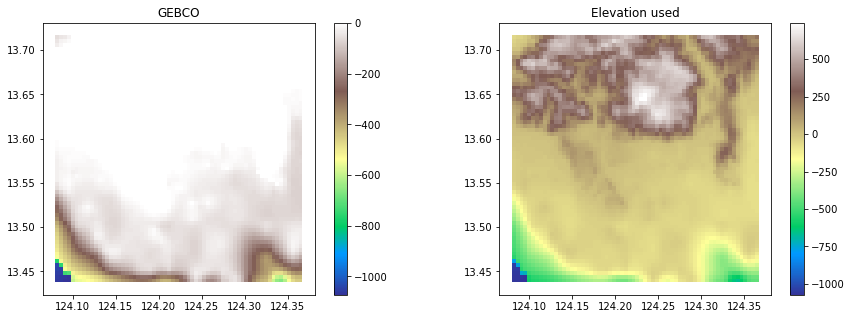

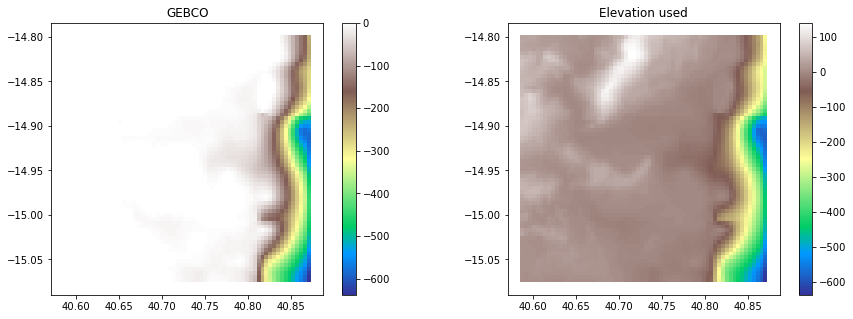

In [64]:
# inspect low elevation data
print(f"elev < -1000m {gdf[gdf['elevation'] < -1000]['event'].unique()}")
print(f"elev < -500m {gdf[gdf['elevation'] < -500]['event'].unique()}")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
gdf[gdf['event'] == 'goni_virac_0'].plot('gebco', ax=ax[0], cmap='terrain', legend=True)
ax[0].set_title('GEBCO')
gdf[gdf['event'] == 'goni_virac_0'].plot('elevation', ax=ax[1], cmap='terrain', legend=True);
ax[1].set_title('Elevation used');

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
gdf[gdf['event'] == 'gombe_mossuril_3'].plot('gebco', ax=ax[0], cmap='terrain', legend=True)
ax[0].set_title('GEBCO')
gdf[gdf['event'] == 'gombe_mossuril_3'].plot('elevation', ax=ax[1], cmap='terrain', legend=True);
ax[1].set_title('Elevation used');